In [49]:
import datetime as dt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
import statsmodels.api as sm


# initialization
prob_switch = 0.2
stdev = 0.012623971978355785 # S&P500 전구간 stdev
R1, R2, R3 = 0.012, -0.009, 0.006 # return init value
INNER_STEPS = 10


def _gen_data(phi1, phi2, phi3, flag, stdev, drift, steps):
    # Initial values for lagged returns
    r1, r2, r3 = R1, R2, R3
    # Create data set based on AR(p)
    rets, flags = [], []
    for _ in range(0, steps):
        rt = drift + phi1*r1 + phi2*r2 + phi3*r3 + np.random.normal(loc=0, scale=stdev, size=1)
        flags.append(flag)
        rets.append(float(rt))
        r3, r2, r1 = r2, r1, rt
    return rets, flags


def _gen_dual_regime(phi, steps, inner_steps, prob_switch, stdev):
    rets, flags, is_regime_two = [], [], 0
    for _ in range(0, steps):
        is_regime_two =  np.random.uniform() < prob_switch

        if is_regime_two:
            rets_regime, flags_regime = _gen_data(phi1=-phi[0], phi2=-phi[1], phi3=-phi[2],
                                                  flag=1, steps=inner_steps,
                                                  stdev=stdev, drift=-0.0001)
        else:
            rets_regime, flags_regime = _gen_data(phi1=phi[0], phi2=phi[1], phi3=phi[2],
                                                  flag=0, steps=inner_steps,
                                                  stdev=stdev, drift=0.0001)
        rets.extend(rets_regime)
        flags.extend(flags_regime)
    return rets, flags


def dual_regime(total_steps, phi, prob_switch=prob_switch, stdev=stdev):
    # Params
    inner_steps = INNER_STEPS
    steps = int(total_steps / inner_steps)  # Set steps so that total steps is reached

    # Gen dual regime data
    rets, flags = _gen_dual_regime(phi = phi, steps=steps, inner_steps=inner_steps,
                                   prob_switch=prob_switch, stdev=stdev)

    # Convert to DF
    date_range = pd.date_range(end=dt.datetime.now(),
                               periods=steps * inner_steps,
                               freq='d', normalize=True)

    data = pd.DataFrame({'rets': np.array(rets).flatten(), 'flags': flags}, index=date_range)
    return data, get_SNR(data)


def prep_data(data, with_flags=True):
    # Set target variable
    data['target'] = data['rets'].apply(lambda x: 0 if x < 0 else 1).shift(-1)  # Binary classification
    data['target_rets'] = data['rets'].shift(-1)  # Add target rets for debugging
    data.dropna(inplace=True)

    # Auto-correlation trading rule: trade sign of previous day.
    data['pmodel'] = data['rets'].apply(lambda x: 1 if x > 0.0 else 0)

    # Strategy daily returns
    data['prets'] = (data['pmodel'] * data['target_rets']).shift(1)  # Lag by 1 to remove look ahead and align dates
    data.dropna(inplace=True)

    # Add lag rets 2 and 3 for Logistic regression
    data['rets2'] = data['rets'].shift(1)
    data['rets3'] = data['rets'].shift(2)

    # Add Regime indicator if with_flags is on
    if with_flags:
        data['regime'] = data['flags'].shift(5)

    model_data = data[data['pmodel'] == 1]
    return model_data.dropna(), data


def get_SNR(data):
    data = data['rets']
    data = pd.concat([data, data.shift(1), data.shift(2), data.shift(3)], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
    data = sm.tools.tools.add_constant(data)
    data.columns = ['Const', 'ret', 'ret(1)', 'ret(2)', 'ret(3)']
    model = sm.OLS(data['ret'], data.loc[:,['Const', 'ret(1)', 'ret(2)', 'ret(3)']])
    results = model.fit()
    return results.rsquared


def classification_stats(actual, predicted, prefix, get_specificity):
    # Create Report
    report = classification_report(actual, predicted, output_dict=True,
                                   labels=[0, 1], zero_division=0)
    # Extract (long only) metrics
    report['1'][prefix + '_accuracy'] = report['accuracy']
    report['1'][prefix + '_auc'] = roc_auc_score(actual, predicted)
    report['1'][prefix + '_macro_avg_f1'] = report['macro avg']['f1-score']
    report['1'][prefix + '_weighted_avg'] = report['weighted avg']['f1-score']

    # To DataFrame
    row = pd.DataFrame.from_dict(report['1'], orient='index').T
    row.columns = [prefix + '_precision', prefix + '_recall', prefix + '_f1_score',
                    prefix + '_support', prefix + '_accuracy', prefix + '_auc',
                    prefix + '_macro_avg_f1', prefix + '_weighted_avg_f1']

    # Add Specificity
    if get_specificity:
        row[prefix + '_specificity'] = report['0']['recall']
    else:
        row[prefix + '_specificity'] = 0

    return row

def de_prado_bet_size(prob_series, clip=True):
    # Can't compute for p = 1 or p = 0, leads to inf.
    p = prob_series.copy()
    p[p == 1] = 0.99999
    p[p == 0] = 0.00001
    # Getting max value from training set
    num_classes = 2
    dp_sizes = (p - 1 / num_classes) / ((p * (1 - p)) ** 0.5)
    dp_t_sizes = dp_sizes.apply(lambda s: norm.cdf(s))
    dp_bet_sizes = dp_t_sizes
    # no sigmoid function, only clipping?
    dp_bet_sizes[dp_bet_sizes < 0.5] = 0
    return dp_bet_sizes

def target_sigmoid(x):
    # Apply sigmoid position sizing
    f = lambda p: min(max(1 / (1 + np.exp(-x[0] * p - x[1])), 0), 1)
    f = np.vectorize(f)
    # Backtest + sharpe ratio
    rets = f(prob_train[prob_train > 0.5]) * target_train_p[prob_train > 0.5]
    # Solve for no positions taken
    mean, stdev = check_stats(rets)
    # Sharpe Ratio
    sharp_ratio = mean / stdev
    return -sharp_ratio

def target_iso_sigmoid(x):
    # Apply sigmoid position sizing
    f = lambda p: min(max(1 / (1 + np.exp(-x[0] * p - x[1])), 0), 1)
    f = np.vectorize(f)
    # Backtest + sharpe ratio
    rets = f(prob_sigmoid_train[prob_sigmoid_train > 0.5]) * target_train_p[prob_sigmoid_train > 0.5]
    # Solve for no positions taken
    mean, stdev = check_stats(rets)
    # Sharpe Ratio
    sharp_ratio = mean / stdev
    return -sharp_ratio

def check_stats(rets):
    if np.std(rets) == 0.0:
        stdev = 10000
    else:
        stdev = np.std(rets)

    if (np.mean(rets) <= 0.00001) and (np.mean(rets) >= -0.00001):
        mean = -10000
    else:
        mean = np.mean(rets)

    return mean, stdev


def target_linear(x):
    # Linear function
    f = lambda p: min(max(x[0] * p + x[1], 0), 1)
    f = np.vectorize(f)
    # Backtest
    rets = f(prob_train[prob_train > 0.5]) * target_train_p[prob_train > 0.5]
    # Solve for no positions taken
    mean, stdev = check_stats(rets)
    # Sharpe Ratio
    sr = mean / stdev
    return -sr


def target_linear_iso(x):
    # Linear function
    f = lambda p: min(max(x[0] * p + x[1], 0), 1)
    f = np.vectorize(f)
    # Backtest
    rets = f(prob_sigmoid_train[prob_sigmoid_train > 0.5]) * target_train_p[prob_sigmoid_train > 0.5]
    # Solve for no positions taken
    mean, stdev = check_stats(rets)
    # Sharp Ratio
    sr = mean / stdev
    return -sr


def kelly(p, win, loss):
    return (p / abs(loss)) - ((1 - p) / win)

def clip_kelly(b):
    return np.min([np.max([b, 0]), 1])

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import numpy as np


def plot_calibration_curve(y_true, y_prob, n_bins=10, ax=None, hist=True, normalize=False):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, normalize=normalize)
    if ax is None:
        ax = plt.gca()
    if hist:
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of positive samples")
    ax.set(aspect='equal')
    return curve

In [50]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as sp
import neptune
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve
from sklearn.preprocessing import StandardScaler
import quantstats as qs
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import brier_score_loss, f1_score, precision_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

hparams_ = {'steps': [200, 2000, 10000], 'SNR':[[-0.05, -0.05, 0.1], [0.4, -0.45, -0.4], [0.6, -0.45, 0.65]],
            'max_samples':[round(x,2) for x in np.linspace(0.6, 0.8, 2)], 'ccp_alpha':[round(x,4) for x in np.linspace(0., 0.001, 2)]}
hparams = (dict(zip(hparams_, i)) for i in product(*hparams_.values()))

dual_regime(phi = [0.6, -0.45, 0.65], total_steps = 200)

(                rets  flags
 2022-11-18  0.015253      0
 2022-11-19 -0.002013      0
 2022-11-20 -0.000179      0
 2022-11-21  0.010804      0
 2022-11-22  0.005359      0
 ...              ...    ...
 2023-06-01 -0.001680      0
 2023-06-02  0.003701      0
 2023-06-03  0.006547      0
 2023-06-04  0.001274      0
 2023-06-05  0.000302      0
 
 [200 rows x 2 columns],
 0.5633051783254013)

In [51]:
data1, snr1 = dual_regime(phi = [0.6, -0.45, 0.65], total_steps = 2000)
data1

,rets,flags
2017-12-14,0.015292,0
2017-12-15,-0.002012,0
2017-12-16,-0.000205,0
2017-12-17,0.010857,0
2017-12-18,0.005393,0
...,...,...
2023-06-01,-0.001619,0
2023-06-02,0.003744,0
2023-06-03,0.006570,0
2023-06-04,0.001315,0


In [52]:
data2, snr2 = dual_regime(phi = [-0.05, -0.05, 0.1], total_steps = 2000)
data2

,rets,flags
2017-12-14,0.000555,0
2017-12-15,-0.001431,0
2017-12-16,0.001336,0
2017-12-17,0.000160,0
2017-12-18,-0.000128,0
...,...,...
2023-06-01,0.000005,1
2023-06-02,-0.000139,1
2023-06-03,-0.000076,1
2023-06-04,-0.000128,1


<Axes: >

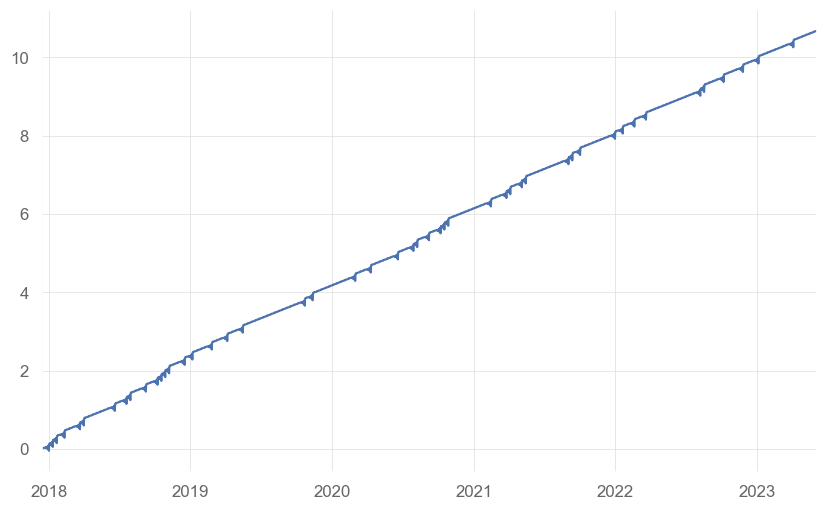

In [53]:
data1.rets.cumsum().plot() # high signal

<Axes: >

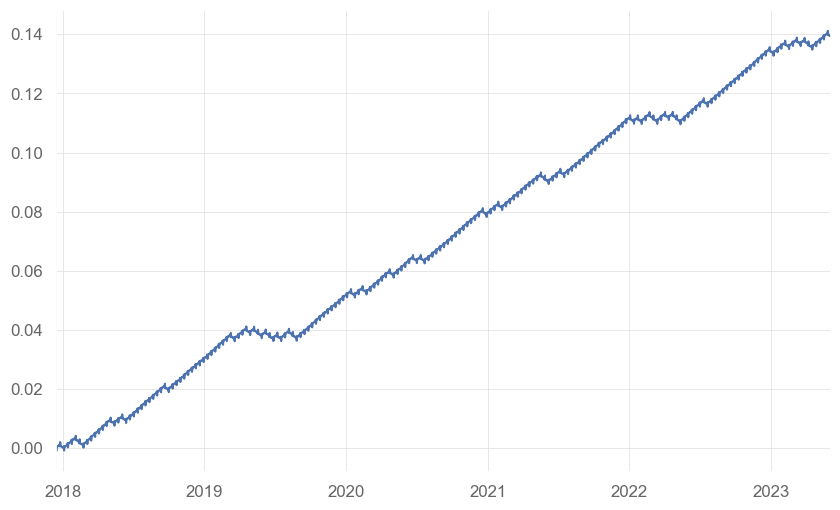

In [54]:
data2.rets.cumsum().plot() # low signal

In [55]:
data3, snr3 = dual_regime(phi = [0.4, -0.45, -0.4], total_steps = 2000)
data3

,rets,flags
2017-12-14,0.006516,0
2017-12-15,0.000911,0
2017-12-16,-0.007251,0
2017-12-17,-0.005791,0
2017-12-18,0.000633,0
...,...,...
2023-06-01,0.005928,0
2023-06-02,0.004445,0
2023-06-03,-0.001056,0
2023-06-04,-0.004696,0


<Axes: >

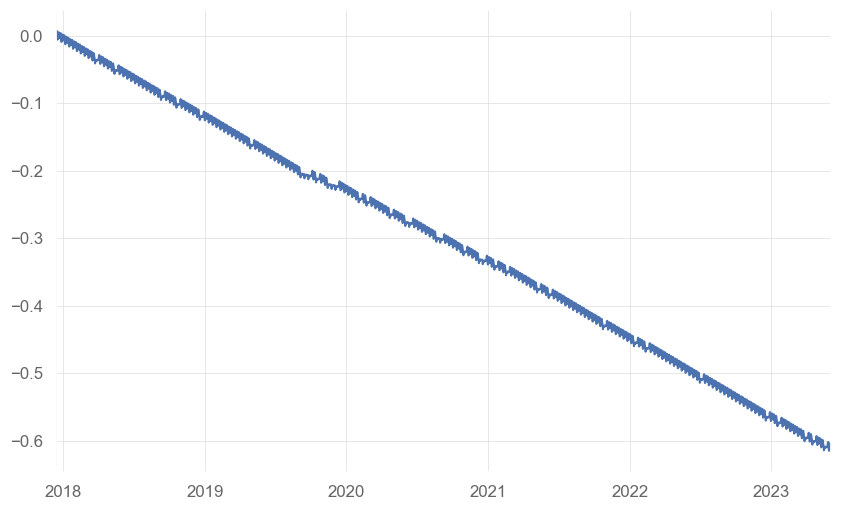

In [56]:
data3.rets.cumsum().plot()

In [ ]:
model_data1, data1 = prep_data(data=data1, with_flags=True)

In [ ]:
model_data1

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime
2017-12-19,0.008402,0,0.0,-0.000078,1,0.000000,-0.019040,-0.022005,0.0
2017-12-22,0.017500,0,1.0,0.034206,1,0.000000,-0.007206,-0.000078,0.0
2017-12-23,0.034206,0,0.0,-0.005477,1,0.034206,0.017500,-0.007206,0.0
2017-12-25,0.000845,0,1.0,0.010426,1,0.000000,-0.005477,0.034206,0.0
2017-12-26,0.010426,0,1.0,0.011963,1,0.010426,0.000845,-0.005477,0.0
...,...,...,...,...,...,...,...,...,...
2023-05-29,0.017431,0,1.0,0.026122,1,0.000000,-0.001374,-0.005118,0.0
2023-05-30,0.026122,0,1.0,0.021073,1,0.026122,0.017431,-0.001374,0.0
2023-05-31,0.021073,0,1.0,0.009975,1,0.021073,0.026122,0.017431,0.0
2023-06-01,0.009975,0,1.0,0.004275,1,0.009975,0.021073,0.026122,0.0


In [ ]:
data1

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime
2017-12-14,-0.026362,0,0.0,-0.009032,0,-0.026362,NaN,NaN,NaN
2017-12-15,-0.009032,0,1.0,0.003188,0,-0.000000,-0.026362,NaN,NaN
2017-12-16,0.003188,0,0.0,-0.022005,1,0.000000,-0.009032,-0.026362,NaN
2017-12-17,-0.022005,0,0.0,-0.019040,0,-0.022005,0.003188,-0.009032,NaN
2017-12-18,-0.019040,0,1.0,0.008402,0,-0.000000,-0.022005,0.003188,NaN
...,...,...,...,...,...,...,...,...,...
2023-05-30,0.026122,0,1.0,0.021073,1,0.026122,0.017431,-0.001374,0.0
2023-05-31,0.021073,0,1.0,0.009975,1,0.021073,0.026122,0.017431,0.0
2023-06-01,0.009975,0,1.0,0.004275,1,0.009975,0.021073,0.026122,0.0
2023-06-02,0.004275,0,0.0,-0.009918,1,0.004275,0.009975,0.021073,0.0


<Axes: >

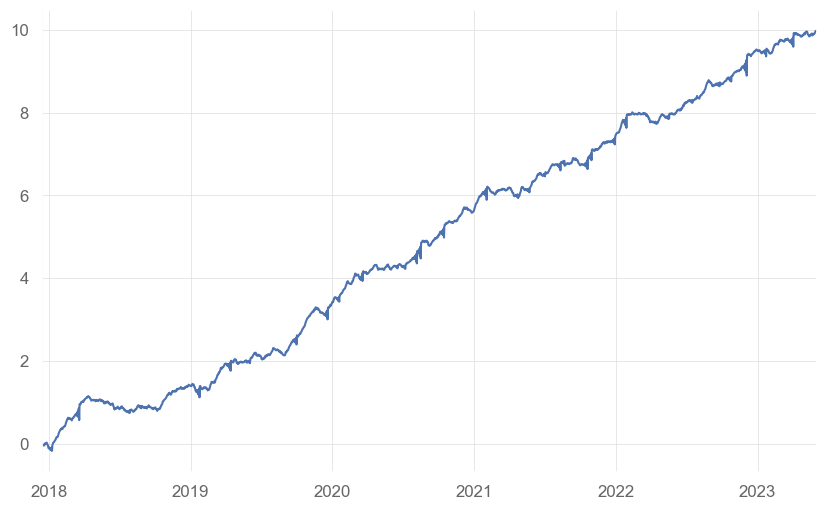

In [ ]:
data1.target_rets.cumsum().plot()

In [ ]:
model_data1

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime
2017-12-19,0.008402,0,0.0,-0.000078,1,0.000000,-0.019040,-0.022005,0.0
2017-12-22,0.017500,0,1.0,0.034206,1,0.000000,-0.007206,-0.000078,0.0
2017-12-23,0.034206,0,0.0,-0.005477,1,0.034206,0.017500,-0.007206,0.0
2017-12-25,0.000845,0,1.0,0.010426,1,0.000000,-0.005477,0.034206,0.0
2017-12-26,0.010426,0,1.0,0.011963,1,0.010426,0.000845,-0.005477,0.0
...,...,...,...,...,...,...,...,...,...
2023-05-29,0.017431,0,1.0,0.026122,1,0.000000,-0.001374,-0.005118,0.0
2023-05-30,0.026122,0,1.0,0.021073,1,0.026122,0.017431,-0.001374,0.0
2023-05-31,0.021073,0,1.0,0.009975,1,0.021073,0.026122,0.017431,0.0
2023-06-01,0.009975,0,1.0,0.004275,1,0.009975,0.021073,0.026122,0.0


In [ ]:
scaler = StandardScaler()
train, test = train_test_split(model_data1, test_size=0.3, shuffle=False)
X_train_regime = train[['rets', 'rets2', 'rets3', 'regime']]; y_train = train['target']
X_test_regime = test[['rets', 'rets2', 'rets3', 'regime']]; y_test = test['target']

In [ ]:
X_train_regime_scaled = scaler.fit_transform(X_train_regime[['rets', 'rets2', 'rets3']])
regime = X_train_regime['regime'].values.reshape((-1, 1))
X_train_regime_scaled = np.append(X_train_regime_scaled, regime, axis=1)

In [ ]:
X_test_regime_scaled = scaler.transform(X_test_regime[['rets', 'rets2', 'rets3']])
regime = X_test_regime['regime'].values.reshape((-1, 1))
X_test_regime_scaled = np.append(X_test_regime_scaled, regime, axis=1)

In [ ]:
trained_model = RandomForestClassifier(n_estimators = 1000, ccp_alpha = 0.001, max_samples = 80)
fit = trained_model.fit(X_train_regime_scaled, y_train)

In [ ]:
untrained_model = RandomForestClassifier(n_estimators = 1000, ccp_alpha = 0.001, max_samples = 80)

              precision    recall  f1-score   support

    no trade       0.73      0.53      0.62       159
       trade       0.68      0.84      0.75       190

    accuracy                           0.70       349
   macro avg       0.71      0.69      0.68       349
weighted avg       0.71      0.70      0.69       349



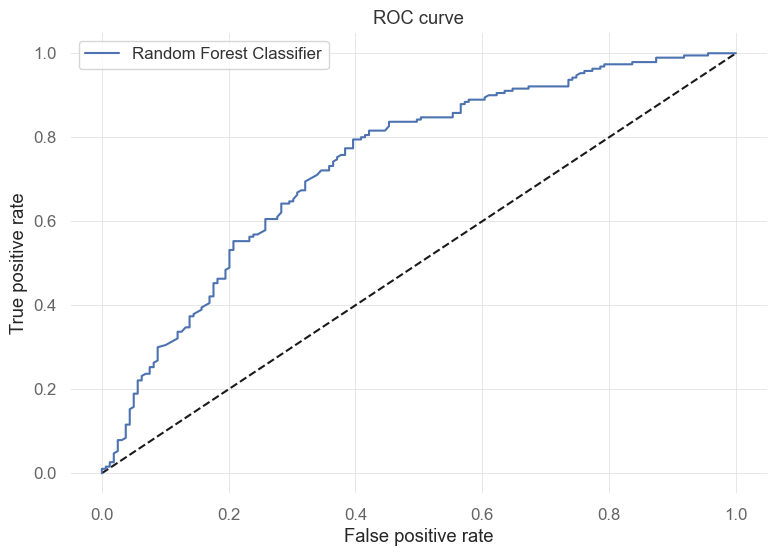

In [ ]:
from sklearn import metrics
y_pred_rf = fit.predict_proba(X_test_regime_scaled)[:, 1]
y_pred = fit.predict(X_test_regime_scaled)
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_pred_rf)
print(metrics.classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
model_data2, data2 = prep_data(data=data2, with_flags=True)

In [ ]:
model_data2

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime
2017-12-19,0.007603,0,1.0,0.006435,1,0.007603,0.023280,0.020874,0.0
2017-12-20,0.006435,0,0.0,-0.008262,1,0.006435,0.007603,0.023280,0.0
2017-12-23,0.008402,1,1.0,0.022825,1,0.000000,-0.006811,-0.008262,0.0
2017-12-24,0.022825,1,1.0,0.004611,1,0.022825,0.008402,-0.006811,0.0
2017-12-25,0.004611,1,0.0,-0.014444,1,0.004611,0.022825,0.008402,0.0
...,...,...,...,...,...,...,...,...,...
2023-05-28,0.005157,0,0.0,-0.012909,1,0.005157,0.010623,-0.007703,0.0
2023-05-31,0.014954,0,1.0,0.004300,1,0.000000,-0.024142,-0.012909,0.0
2023-06-01,0.004300,0,1.0,0.001862,1,0.004300,0.014954,-0.024142,0.0
2023-06-02,0.001862,0,1.0,0.006113,1,0.001862,0.004300,0.014954,0.0


In [ ]:
scaler = StandardScaler()
train, test = train_test_split(model_data2, test_size=0.3, shuffle=False)
X_train_regime = train[['rets', 'rets2', 'rets3', 'regime']]; y_train = train['target']
X_test_regime = test[['rets', 'rets2', 'rets3', 'regime']]; y_test = test['target']

In [ ]:
X_train_regime_scaled = scaler.fit_transform(X_train_regime[['rets', 'rets2', 'rets3']])
regime = X_train_regime['regime'].values.reshape((-1, 1))
X_train_regime_scaled = np.append(X_train_regime_scaled, regime, axis=1)

In [ ]:
X_test_regime_scaled = scaler.transform(X_test_regime[['rets', 'rets2', 'rets3']])
regime = X_test_regime['regime'].values.reshape((-1, 1))
X_test_regime_scaled = np.append(X_test_regime_scaled, regime, axis=1)

In [ ]:
trained_model = RandomForestClassifier(n_estimators = 1000, ccp_alpha = 0.001, max_samples = 80)
fit = trained_model.fit(X_train_regime_scaled, y_train)

In [ ]:
untrained_model = RandomForestClassifier(n_estimators = 1000, ccp_alpha = 0.001, max_samples = 80)

              precision    recall  f1-score   support

    no trade       0.59      0.69      0.64       157
       trade       0.58      0.46      0.51       142

    accuracy                           0.58       299
   macro avg       0.58      0.58      0.57       299
weighted avg       0.58      0.58      0.58       299



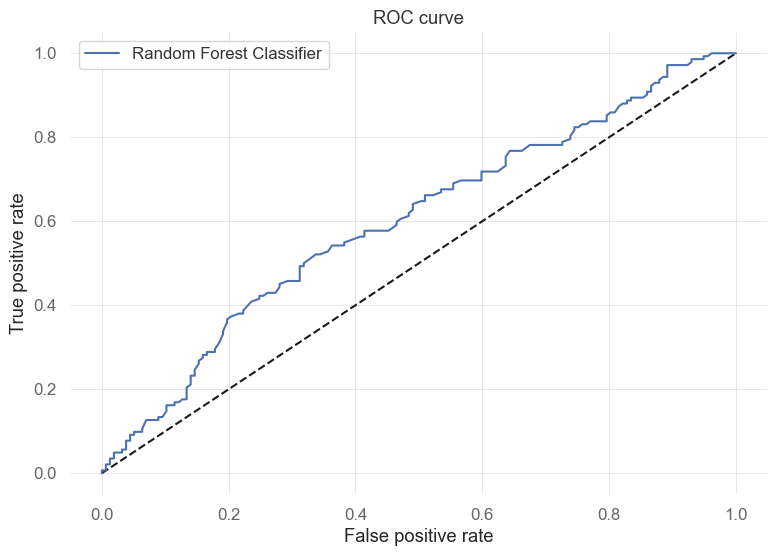

In [ ]:
from sklearn import metrics
y_pred_rf = fit.predict_proba(X_test_regime_scaled)[:, 1]
y_pred = fit.predict(X_test_regime_scaled)
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_pred_rf)
print(metrics.classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
model_data3, data3 = prep_data(data=data3, with_flags=True)

In [ ]:
model_data2

,rets,flags,target,target_rets,pmodel,prets,rets2,rets3,regime
2017-12-19,0.007603,0,1.0,0.006435,1,0.007603,0.023280,0.020874,0.0
2017-12-20,0.006435,0,0.0,-0.008262,1,0.006435,0.007603,0.023280,0.0
2017-12-23,0.008402,1,1.0,0.022825,1,0.000000,-0.006811,-0.008262,0.0
2017-12-24,0.022825,1,1.0,0.004611,1,0.022825,0.008402,-0.006811,0.0
2017-12-25,0.004611,1,0.0,-0.014444,1,0.004611,0.022825,0.008402,0.0
...,...,...,...,...,...,...,...,...,...
2023-05-28,0.005157,0,0.0,-0.012909,1,0.005157,0.010623,-0.007703,0.0
2023-05-31,0.014954,0,1.0,0.004300,1,0.000000,-0.024142,-0.012909,0.0
2023-06-01,0.004300,0,1.0,0.001862,1,0.004300,0.014954,-0.024142,0.0
2023-06-02,0.001862,0,1.0,0.006113,1,0.001862,0.004300,0.014954,0.0


In [ ]:
scaler = StandardScaler()
train, test = train_test_split(model_data3, test_size=0.3, shuffle=False)
X_train_regime = train[['rets', 'rets2', 'rets3', 'regime']]; y_train = train['target']
X_test_regime = test[['rets', 'rets2', 'rets3', 'regime']]; y_test = test['target']

In [ ]:
X_train_regime_scaled = scaler.fit_transform(X_train_regime[['rets', 'rets2', 'rets3']])
regime = X_train_regime['regime'].values.reshape((-1, 1))
X_train_regime_scaled = np.append(X_train_regime_scaled, regime, axis=1)

In [ ]:
X_test_regime_scaled = scaler.transform(X_test_regime[['rets', 'rets2', 'rets3']])
regime = X_test_regime['regime'].values.reshape((-1, 1))
X_test_regime_scaled = np.append(X_test_regime_scaled, regime, axis=1)

In [ ]:
trained_model = RandomForestClassifier(n_estimators = 1000, ccp_alpha = 0.001, max_samples = 80)
fit = trained_model.fit(X_train_regime_scaled, y_train)

In [ ]:
untrained_model = RandomForestClassifier(n_estimators = 1000, ccp_alpha = 0.001, max_samples = 80)

              precision    recall  f1-score   support

    no trade       0.69      0.48      0.57       141
       trade       0.62      0.79      0.69       148

    accuracy                           0.64       289
   macro avg       0.65      0.64      0.63       289
weighted avg       0.65      0.64      0.63       289



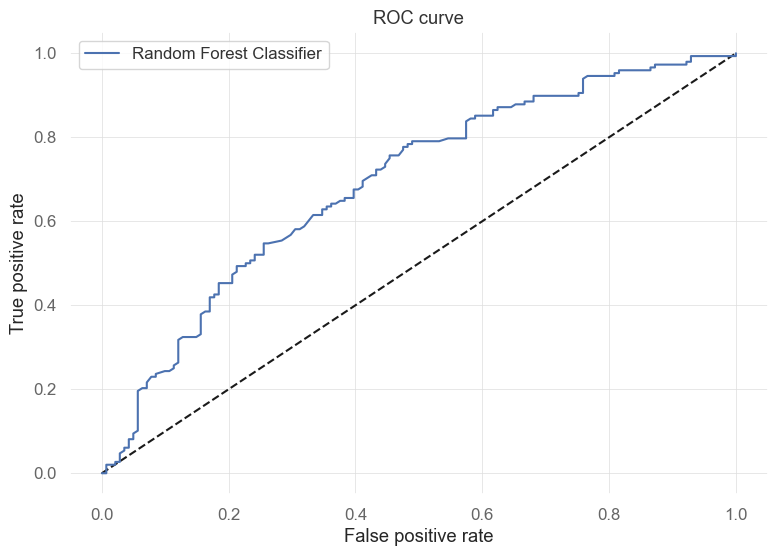

In [ ]:
from sklearn import metrics
y_pred_rf = fit.predict_proba(X_test_regime_scaled)[:, 1]
y_pred = fit.predict(X_test_regime_scaled)
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_pred_rf)
print(metrics.classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (9,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
def plotMetrics(X_test, y_test) :
    y_pred_rf = fit.predict_proba(X_test)[:, 1]
    y_pred = fit.predict(X_test)
    fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_pred_rf)
    print(metrics.classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

    plt.figure(figsize = (9,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label = 'Random Forest Classifier')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

              precision    recall  f1-score   support

    no trade       0.69      0.48      0.57       141
       trade       0.62      0.79      0.69       148

    accuracy                           0.64       289
   macro avg       0.65      0.64      0.63       289
weighted avg       0.65      0.64      0.63       289



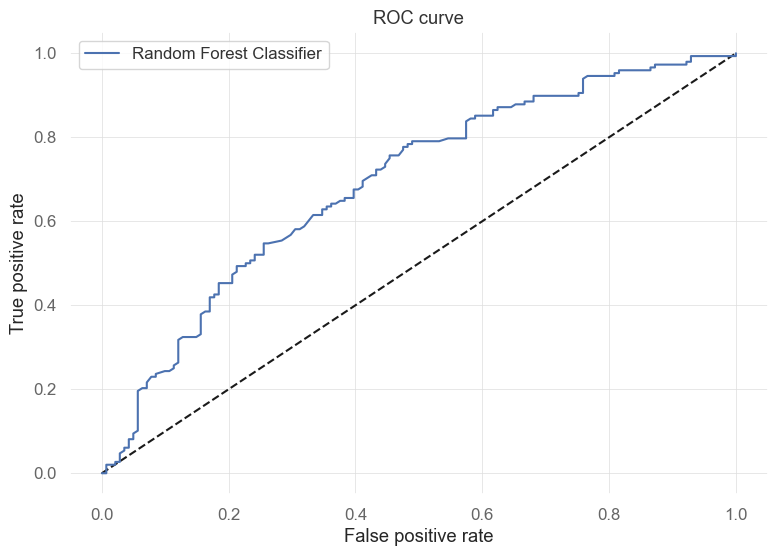

In [ ]:
plotMetrics(X_test_regime_scaled, y_test)

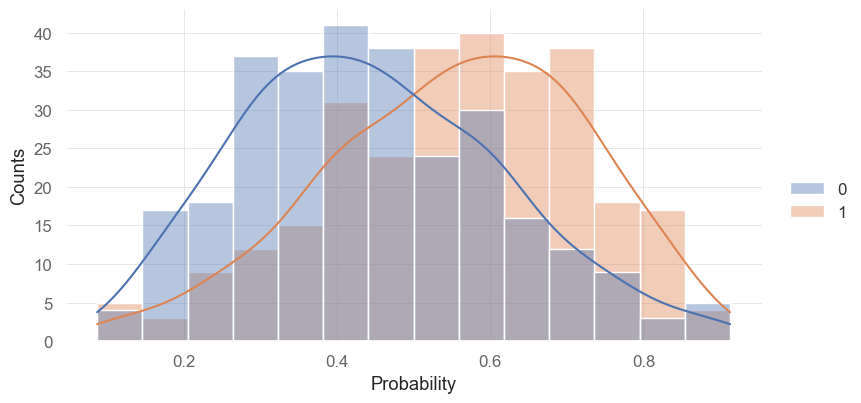

In [ ]:
import seaborn as sns
ax = sns.displot(fit.predict_proba(X_test_regime_scaled), height = 4, aspect = 2, alpha = 0.4, kde = True)
ax.set_xlabels('Probability')
ax.set_ylabels('Counts')

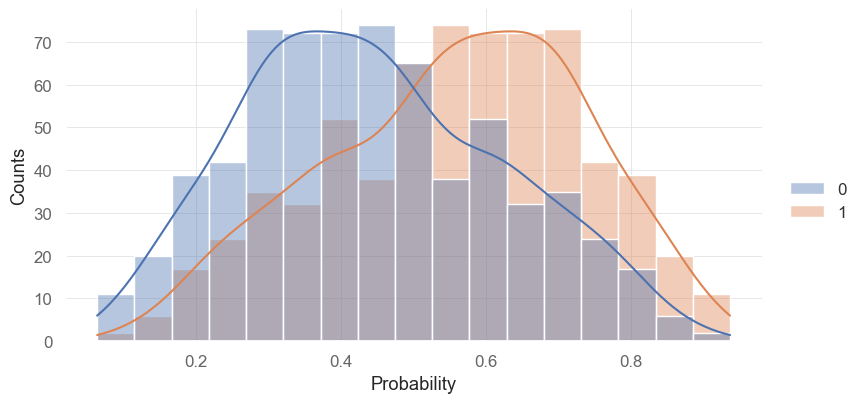

In [ ]:
ax = sns.displot(fit.predict_proba(X_train_regime_scaled), height = 4, aspect = 2, alpha = 0.4, kde = True)
ax.set_xlabels('Probability')
ax.set_ylabels('Counts')

In [ ]:
def plotMetrics(X_test, y_test, fit, ax = None, hist = True) :
    y_pred_rf = fit.predict_proba(X_test)[:, 1]
    y_pred = fit.predict(X_test)
    fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_pred_rf)
    print(metrics.classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

    if ax is None :
        ax = plt.gca()

    if hist :
        ax.displot(fit.predict_proba(X_test), height=4, aspect=2, alpha=0.4, kde=True)

    ax.set_xlabels('Probability')
    ax.set_ylabels('Counts')

    return ax

              precision    recall  f1-score   support

    no trade       0.69      0.48      0.57       141
       trade       0.62      0.79      0.69       148

    accuracy                           0.64       289
   macro avg       0.65      0.64      0.63       289
weighted avg       0.65      0.64      0.63       289



AttributeError: 'Axes' object has no attribute 'displot'

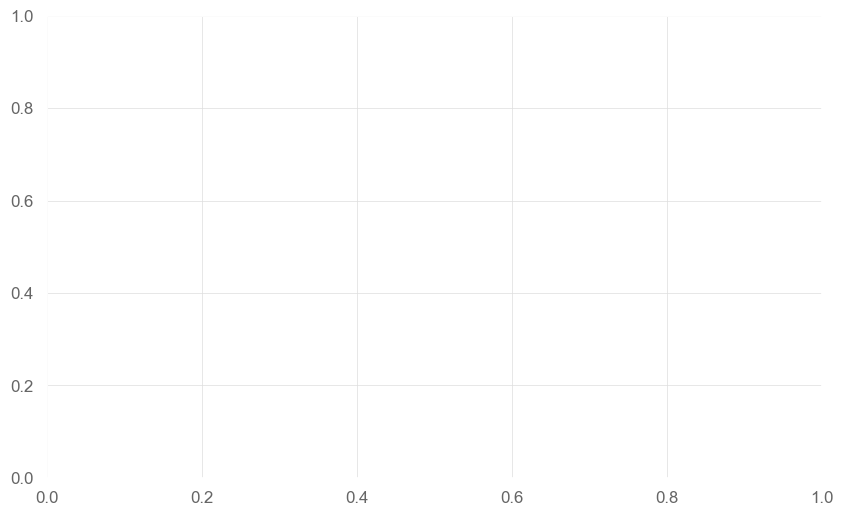

In [ ]:
ax = plotMetrics(X_test_regime_scaled, y_test, fit)

In [ ]:
sns.distplot([pd.DataFrame(fit.predict_proba(X_train_regime_scaled))[[0]], pd.DataFrame(fit.predict_proba(X_train_regime_scaled))[[1]]], kde=True, label = "0")

In [ ]:
fit.predict_proba(X_train_regime_scaled)

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(3, 1, 1)

In [62]:
import pandas_datareader as web
import datetime

start = datetime.datetime(1980, 1, 1)
end = datetime.datetime(2023, 5, 31)
df_null = web.DataReader("KOSPI", "naver", start, end)
df = df_null['Close'].dropna().astype('float')

In [63]:
ret = (np.log(df) - np.log(df.shift(1))) / df.shift(1)
ret.std()

2.338087004739937e-05

<Axes: xlabel='Date'>

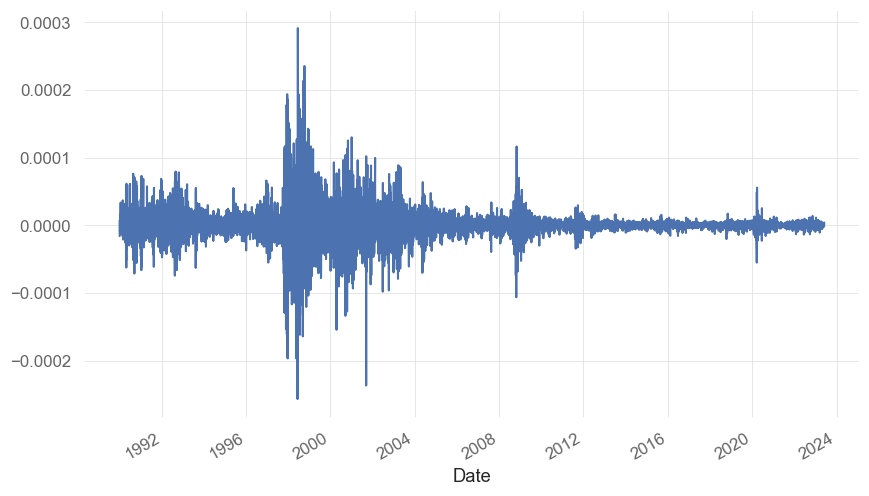

In [65]:
ret.plot()

In [66]:
ret.std()

2.338087004739937e-05